# iForest

In [1]:
import warnings
warnings.filterwarnings('ignore')

## General libraries

In [2]:
import os
import sys

import pandas as pd
import numpy as np

from os.path import join
import json
import datetime

import time

from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import train_test_split

### Load enviroment variables

In [3]:
from dotenv import load_dotenv
load_dotenv('../.env')

code_root = os.environ['CODE_ROOT']
cfg_path = os.environ['CFG_PATH']
data_root = os.environ['DATA_ROOT']

sys.path.insert(0, code_root)

## Specific libraries

In [4]:
from src.load.functions import get_fs_dataset, fs_datasets_hyperparams

from src.feature_selection.functions import shap_feature_selection, process_fi

from src.utils.functions import adjust_fi

from src.model.functions import run_model_experiment

from src.plots.functions import plots_metrics

## Parameters

In [5]:
seed = 123
iterations = 10
gamma = 0.146
n_estimators_list = [25, 50, 75, 100, 125, 150, 175, 200]
np.random.seed(seed)

dataset_id = 'arrhythmia'
df = get_fs_dataset(dataset_id, data_root)
hyper = fs_datasets_hyperparams(dataset_id)

In [6]:
df.head()

,Col1,Col2,Col3,Col4,Col5,Col6,Col7,Col8,Col9,Col10,...,Col266,Col267,Col268,Col269,Col270,Col271,Col272,Col273,Col274,y
0,75.0,0.0,190.0,80.0,91.0,193.0,371.0,174.0,121.0,-16.0,...,0.0,9.0,-0.9,0.0,0.0,0.9,2.9,23.3,49.4,1
1,56.0,1.0,165.0,64.0,81.0,174.0,401.0,149.0,39.0,25.0,...,0.0,8.5,0.0,0.0,0.0,0.2,2.1,20.4,38.8,0
2,54.0,0.0,172.0,95.0,138.0,163.0,386.0,185.0,102.0,96.0,...,0.0,9.5,-2.4,0.0,0.0,0.3,3.4,12.3,49.0,0
3,55.0,0.0,175.0,94.0,100.0,202.0,380.0,179.0,143.0,28.0,...,0.0,12.2,-2.2,0.0,0.0,0.4,2.6,34.6,61.6,0
4,75.0,0.0,190.0,80.0,88.0,181.0,360.0,177.0,103.0,-16.0,...,0.0,13.1,-3.6,0.0,0.0,-0.1,3.9,25.4,62.8,1


### Paths

In [7]:
path_fi_shap = os.path.join(data_root, "outputs", f"{dataset_id}_fi_shap")
path_shap = os.path.join(data_root, "outputs", f"{dataset_id}_shap.parquet")

## Features selected

### Generate/Load data

In [8]:
# Simulated data and settings
gamma, iterations = 0.146, 10

# Split the DataFrame into features (X) and target (y)
X = df.drop('y', axis=1)  # Features (all columns except 'y')
y = df['y']  # Target (the 'y' column)

# Split into training and testing sets
xtr, xte , ytr, yte = train_test_split(X, y, test_size=0.1, random_state=seed)

### Generate the model

In [9]:
# Initialize and train the IsolationForest model
model = IsolationForest(**hyper, random_state=seed)
model.fit(xtr)

IsolationForest(contamination=0.1, random_state=123)

### Features names

In [10]:
feature_names = np.array(X.columns.tolist())

### Selection process

In [11]:
# Example usage:
selected_features_df = shap_feature_selection(model, xtr, xte, feature_names, agnostic=False)
fi_shap_all = process_fi(selected_features_df, 10)
fi_shap_all.to_parquet(path_fi_shap)

In [12]:
fi_shap_all = pd.read_parquet(path_fi_shap)
fi_shap_all = adjust_fi(fi_shap_all)
fi_shap_all

,n_feats,cum_value,cum_value_percentage,n_feats_percentage,feat_selected
0,7,0.329801,10.581778,2.8,"[Col241, Col64, Col1, Col24, Col238, Col258, C..."
1,15,0.611906,19.633257,6.0,"[Col241, Col64, Col1, Col24, Col238, Col258, C..."
2,27,0.936890,30.060486,10.8,"[Col241, Col64, Col1, Col24, Col238, Col258, C..."
3,40,1.245272,39.955028,16.0,"[Col241, Col64, Col1, Col24, Col238, Col258, C..."
4,55,1.558140,49.993532,22.0,"[Col241, Col64, Col1, Col24, Col238, Col258, C..."
5,72,1.872638,60.084302,28.8,"[Col241, Col64, Col1, Col24, Col238, Col258, C..."
6,91,2.175131,69.789932,36.4,"[Col241, Col64, Col1, Col24, Col238, Col258, C..."
7,115,2.491822,79.951065,46.0,"[Col241, Col64, Col1, Col24, Col238, Col258, C..."
8,147,2.804326,89.977901,58.8,"[Col241, Col64, Col1, Col24, Col238, Col258, C..."
9,250,3.116684,100.000000,100.0,"[Col241, Col64, Col1, Col24, Col238, Col258, C..."


### Generate data

In [13]:
# Capture the start time
start_time = datetime.datetime.now()

results = run_model_experiment(fi_shap_all, df, hyper, 
                     gamma=gamma, iterations=iterations, 
                     n_estimators_list=n_estimators_list, seed=seed, 
                     dataset_id=dataset_id)

# Capture the finish time
finish_time = datetime.datetime.now()

# Calculate the duration
duration = finish_time - start_time

print(f"Duration: {duration}")

2024-08-29 16:15:41,277 - INFO - Starting experiment with 7 features.
2024-08-29 16:15:41,281 - INFO - Starting model training with 7 features and 25 estimators.
2024-08-29 16:15:47,257 - INFO - Starting model training with 7 features and 50 estimators.
2024-08-29 16:15:48,841 - INFO - Starting model training with 7 features and 75 estimators.
2024-08-29 16:15:50,947 - INFO - Starting model training with 7 features and 100 estimators.
2024-08-29 16:15:54,122 - INFO - Starting model training with 7 features and 125 estimators.
2024-08-29 16:15:57,857 - INFO - Starting model training with 7 features and 150 estimators.
2024-08-29 16:16:01,735 - INFO - Starting model training with 7 features and 175 estimators.
2024-08-29 16:16:06,136 - INFO - Starting model training with 7 features and 200 estimators.
2024-08-29 16:16:11,025 - INFO - Starting experiment with 15 features.
2024-08-29 16:16:11,027 - INFO - Starting model training with 15 features and 25 estimators.
2024-08-29 16:16:11,888 -

Duration: 0:05:17.226855


In [14]:
results.to_parquet(path_shap)

In [15]:
df = pd.read_parquet(path_shap)

2024-08-29 16:26:29,031 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-08-29 16:26:29,040 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-08-29 16:26:29,159 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-08-29 16:26:29,172 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-08-29 16:26:29,281 - INFO - Using categorical units to plot a list of strings that are all parsable as 

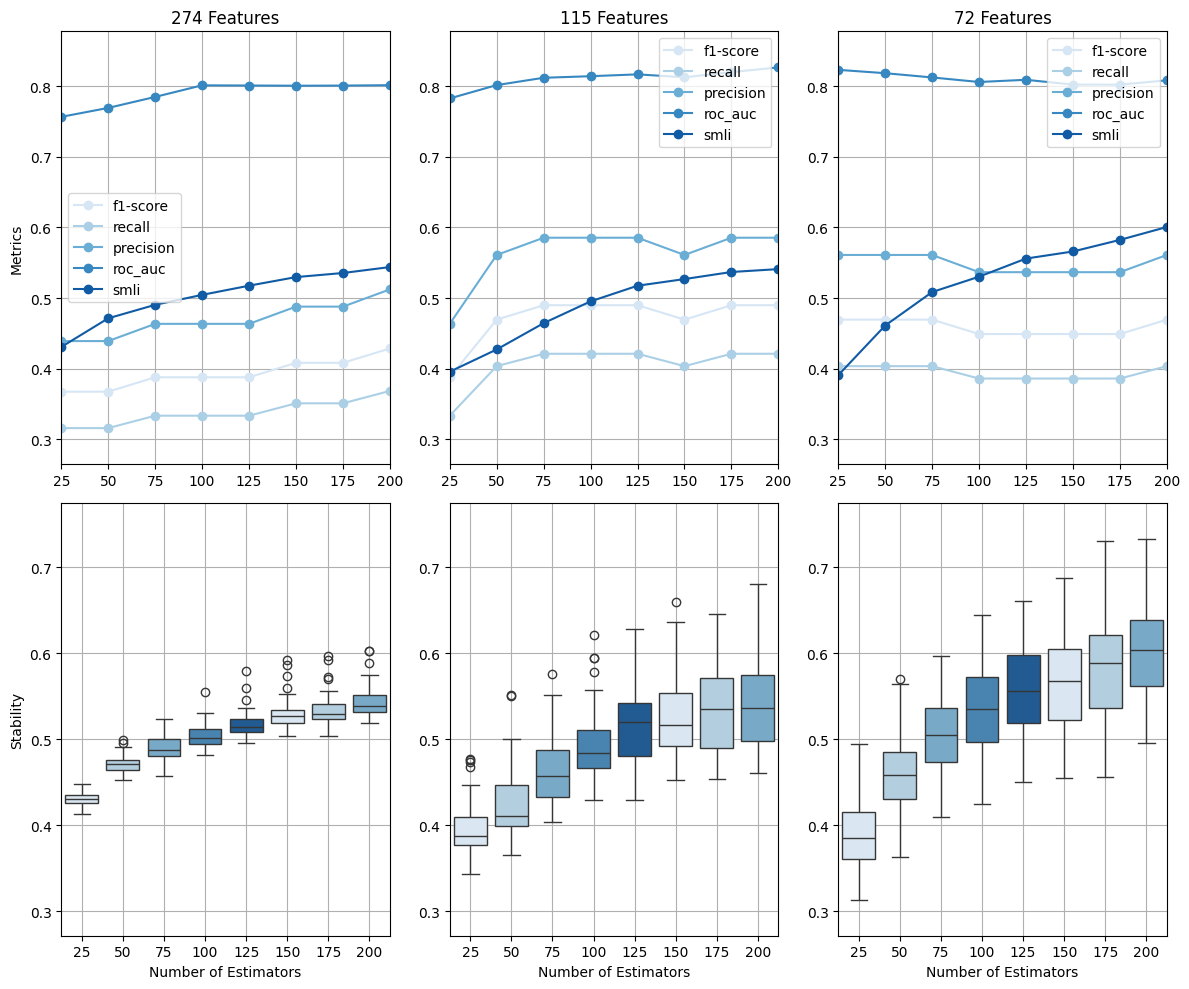

In [26]:
plots_metrics(
    metrics_df=df,
    feat_imp=[100, 80, 60],
    metrics_list=['f1-score', 'recall', 'precision', 'roc_auc', 'smli', 'smli_all'],
    metrics_merge_list=['f1-score', 'precision', 'recall', 'roc_auc', 'smli']
)